# Tickets Management



## Importing Libraries

In [1]:
import pandas as pd
import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display_html, HTML
from itertools import chain,cycle
from scipy.stats import zscore

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df1 = pd.read_excel('./Data/Case_Ticket_Management.xlsx')
df1.head()

,Ticket No,Priority,State,Category,Sub Category,Skill Team,Hosting,Create Date,Picked Date,Completed Date,Assignee,Customer Rating,Outcome,Escalated,Reached via
0,T01,High,California,Data Privacy,GDPR,IT,Vendor Cloud,2021-01-03 12:46:36,2021-01-03 12:48:31,2021-06-03 16:35:26,Bob,Excellent (5),Advised for a risk assessment,NaN,Personal Call
1,T02,Low,Minnesota,Cyber Consultation,BCP/DR,IT,On Prem Server,2021-01-04 09:52:44,2021-01-04 10:12:46,2021-01-17 09:44:31,Bob,Excellent (5),Recommended Threat Assessment,NaN,Ticket Portal
2,T03,High,Maryland,Cyber Security Breach,Firewall,HR,Vendor Cloud,2021-01-04 10:11:07,2021-01-04 10:11:31,2021-01-04 11:43:40,Allan,Excellent (5),Recommended Threat Assessment,NaN,Personal Call
3,T04,Low,New York,Security Gap,Password non-expiry,IT,On Prem Server,2021-01-04 10:55:13,2021-01-04 10:55:31,2021-01-18 11:06:54,Allan,Excellent (5),Advised for a risk assessment,NaN,Ticket Portal
4,T05,High,California,Cyber Security Breach,Malware Attack,Legal,On Prem Cloud,2021-01-04 21:58:33,2021-01-04 22:13:03,2021-01-11 12:20:42,Charlotte,Excellent (5),Recommended Threat Assessment,NaN,Ticket Portal


## Data Validation

The **"Completed Date"** in the data is **not in proper date format**

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ticket No        627 non-null    object        
 1   Priority         627 non-null    object        
 2   State            627 non-null    object        
 3   Category         627 non-null    object        
 4   Sub Category     627 non-null    object        
 5   Skill Team       627 non-null    object        
 6   Hosting          627 non-null    object        
 7   Create Date      627 non-null    datetime64[ns]
 8   Picked Date      627 non-null    datetime64[ns]
 9   Completed Date   627 non-null    object        
 10  Assignee         627 non-null    object        
 11  Customer Rating  627 non-null    object        
 12  Outcome          627 non-null    object        
 13  Escalated        97 non-null     object        
 14  Reached via      627 non-null    object   

In [4]:
def data_info(data):
    
    # Shape
    print("* Shape of data: {}".format(data.shape))
    
    #Duplicates
    print("\n* Duplicates : ",sum(data.duplicated()))
    
    #Checking the index is finite
    if data.index.is_unique:
        print("\n* The index is \033[1;3m unique \033[0m")
    else:
        print('\n* The index is \033[1;3m not unique \033[0m')
    
    # print only missing values
    print(" \033[1;3m \n* Missing values:  \033[0m")
    missing_col =[]
    for col in data.columns:
        if data[col].isna().sum() > 0:
            print(col,':',data[col].isna().sum())
            missing_col.append(col)
    if len(missing_col) == 0:
        print('* No missing values')
    print('\n')
    
    # Datatype
    print("\033[1;3m* Datatype of each colum  \033[0m \n ",data.info())
    
    #\033[1;3m' and '\033[0m

data_info(df1)

* Shape of data: (627, 15)

* Duplicates :  0

* The index is  unique 
  
* Missing values:  
Escalated : 530


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ticket No        627 non-null    object        
 1   Priority         627 non-null    object        
 2   State            627 non-null    object        
 3   Category         627 non-null    object        
 4   Sub Category     627 non-null    object        
 5   Skill Team       627 non-null    object        
 6   Hosting          627 non-null    object        
 7   Create Date      627 non-null    datetime64[ns]
 8   Picked Date      627 non-null    datetime64[ns]
 9   Completed Date   627 non-null    object        
 10  Assignee         627 non-null    object        
 11  Customer Rating  627 non-null    object        
 12  Outcome          627 non-null    obj

In [5]:
df = df1.copy ()

# Improper formating & value in the completed date (Replacing with last date in Feb. 31-02-2021 11:30:57 ---> 2021-02-28 11:30:57)
df.at[598,'Completed Date'] = '2021-02-28 11:30:57'

# update the date format
df['Completed Date'] = pd.to_datetime(df['Completed Date'])

print('Successfully updated...')

Successfully updated...


In [6]:
# Derive new columns
df['Days to pick'] = (df['Picked Date'] - df['Create Date']).dt.days
df['Days to complete'] = (df['Completed Date'] - df['Picked Date']).dt.days

df['day created'] = pd.to_datetime(df['Create Date']).dt.strftime("%a")
df['day picked'] = pd.to_datetime(df['Picked Date']).dt.strftime("%a")
df['day completed'] = pd.to_datetime(df['Completed Date']).dt.strftime("%a")

df['month created'] = pd.to_datetime(df['Create Date']).dt.strftime("%b")
df['month picked'] = pd.to_datetime(df['Picked Date']).dt.strftime("%b")
df['month completed'] = pd.to_datetime(df['Completed Date']).dt.strftime("%b")

# Extract Rating
pattern = r"\((\d+)\)"
df['Rating'] = df['Customer Rating'].str.extract(pattern).astype(int)


df.head()

,Ticket No,Priority,State,Category,Sub Category,Skill Team,Hosting,Create Date,Picked Date,Completed Date,Assignee,Customer Rating,Outcome,Escalated,Reached via,Days to pick,Days to complete,day created,day picked,day completed,month created,month picked,month completed,Rating
0,T01,High,California,Data Privacy,GDPR,IT,Vendor Cloud,2021-01-03 12:46:36,2021-01-03 12:48:31,2021-06-03 16:35:26,Bob,Excellent (5),Advised for a risk assessment,NaN,Personal Call,0,151,Sun,Sun,Thu,Jan,Jan,Jun,5
1,T02,Low,Minnesota,Cyber Consultation,BCP/DR,IT,On Prem Server,2021-01-04 09:52:44,2021-01-04 10:12:46,2021-01-17 09:44:31,Bob,Excellent (5),Recommended Threat Assessment,NaN,Ticket Portal,0,12,Mon,Mon,Sun,Jan,Jan,Jan,5
2,T03,High,Maryland,Cyber Security Breach,Firewall,HR,Vendor Cloud,2021-01-04 10:11:07,2021-01-04 10:11:31,2021-01-04 11:43:40,Allan,Excellent (5),Recommended Threat Assessment,NaN,Personal Call,0,0,Mon,Mon,Mon,Jan,Jan,Jan,5
3,T04,Low,New York,Security Gap,Password non-expiry,IT,On Prem Server,2021-01-04 10:55:13,2021-01-04 10:55:31,2021-01-18 11:06:54,Allan,Excellent (5),Advised for a risk assessment,NaN,Ticket Portal,0,14,Mon,Mon,Mon,Jan,Jan,Jan,5
4,T05,High,California,Cyber Security Breach,Malware Attack,Legal,On Prem Cloud,2021-01-04 21:58:33,2021-01-04 22:13:03,2021-01-11 12:20:42,Charlotte,Excellent (5),Recommended Threat Assessment,NaN,Ticket Portal,0,6,Mon,Mon,Mon,Jan,Jan,Jan,5


In [7]:
# improper dates entered
drp_ind = df[(df['Create Date']>df['Picked Date']) | (df['Picked Date']> df['Completed Date']) | (df['Create Date']> df['Completed Date'])].index
print('Improper date: ', len(drp_ind))
print('Rows in the data: ',df.shape[0])
df.drop(index=drp_ind, inplace= True)
print('Rows after dropping improper values: ',df.shape[0])

print('Successfully updated...')



Improper date:  12
Rows in the data:  627
Rows after dropping improper values:  615
Successfully updated...


## Explorartory Data Analysis

+ Done after removing the improper tickets

In [8]:
# setting up color for max / min value
def set_custom_palette(series, highlight_color = 'turquoise', other_color = 'lightgrey', highlight = 'Max'):
    
    if highlight == 'Max':
        val = series.max()
    if highlight == 'Min':
        val = series.min()
    pal = []
    for item in series:
        if item == val:
            pal.append(highlight_color)
        else:
            pal.append(other_color)
    return pal
 
# Barchart
def barplot(x , y, color = '#79DAE8', orient = None, order = None, palette = None, xlabel = None, ylabel = None, title = None,rotation=None,xlim=None, ylim = None):
    fig, ax = plt.subplots(figsize = (12,8))
    ax = sns.barplot(x=x, y = y,  color = color, order=order,palette = palette, orient = orient)
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=rotation)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    sns.despine(bottom = True, left = True)
    plt.show()

def grp_df(df, groupby_columns, aggregator_coulums):
    out_df = df.groupby(groupby_columns).agg(aggregator_coulums)
    out_df.reset_index(inplace = True)
    return out_df

## Quick Facts

#### what is the easiest way of reaching out to create a ticket?

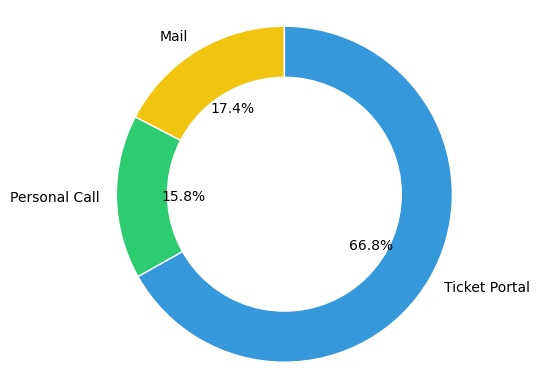

In [9]:
# Create a copy of the validated data to create plots
plt_df = df.copy()

reach = plt_df.groupby('Reached via')['Ticket No'].count()
colors = ['#F1C40F','#2ECC71','#3498DB']
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(reach.values, labels=reach.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'})

# Draw a white circle at the center to create the doughnut effect
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.show()

#### How many tickets were completed in less than a week?

In [10]:
zero_days = plt_df[(plt_df['Days to pick']<=7) & (plt_df['Days to complete']<=7)]
print('Percentage of tickets completed within a week: ',round(zero_days.shape[0]/plt_df.shape[0],2))

Percentage of tickets completed within a week:  0.66


## Trend & Productivity Analysis

In [11]:


# Category for weeks
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekdaycat = pd.api.types.CategoricalDtype(ordered=True, categories=weekday)

# Category for months
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthcat = pd.api.types.CategoricalDtype(ordered=True, categories=month)

# update the days into categorical colums
plt_df['day created'] = plt_df['day created'].astype(weekdaycat)
plt_df['day picked'] = plt_df['day picked'].astype(weekdaycat)
plt_df['day completed'] = plt_df['day completed'].astype(weekdaycat)

# update the month into categorical colums
plt_df['month created'] = plt_df['month created'].astype(monthcat)
plt_df['month picked'] = plt_df['month picked'].astype(monthcat)
plt_df['month completed'] = plt_df['month completed'].astype(monthcat)

#### What is the distribution of tickets picked and completed through out the week?
+ We can observe that **the difference tickets being completed and picked by the team is very small.** 
+ People tend to **pick more cases on Wednesday** and gradually lower.
+ People tend to **complete more cases by Thursday**
+ **Team productivity** throught the week is **0.96**

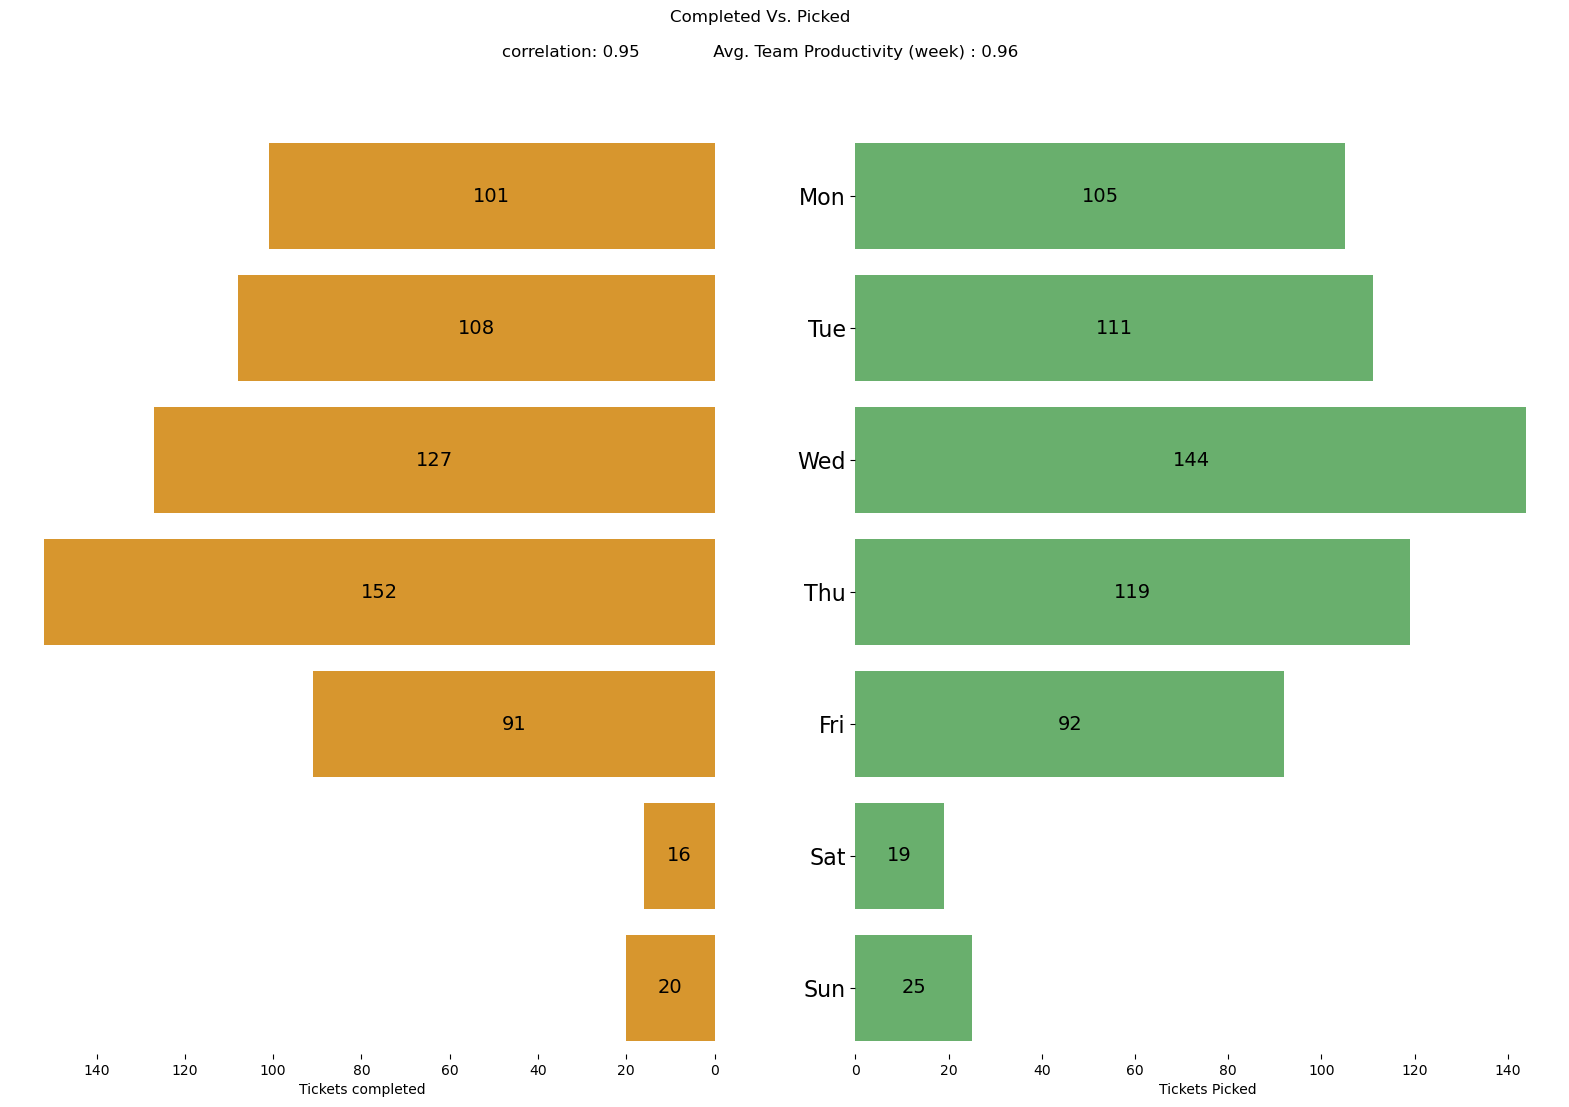

completed Vs. Picked (corelation):  0.95
Team productivity (weekly)):  0.96


In [12]:
# Dataset
cr_dow = plt_df.groupby('day created')['Ticket No'].count()
pk_dow = plt_df.groupby('day picked')['Ticket No'].count()
cmp_dow = plt_df.groupby('day completed')['Ticket No'].count()

# Merge the Datas
week_df = pd.concat([cr_dow, pk_dow, cmp_dow], axis=1)
week_df.columns = [ 'Created','Picked', 'Completed']
week_df['productivity score'] = week_df['Completed'] / week_df['Picked']
week_corr = str(round(week_df['Picked'].corr(week_df['Completed']),2))
week_pd_score = str(round(week_df['productivity score'].mean(),2))
week_df.to_excel('./Data/week trend.xlsx')

# Subplots
fig, ax = plt.subplots(1,2,figsize = (20,12))
fig.suptitle('Completed Vs. Picked\n\n'+'correlation: '+week_corr+'              Avg. Team Productivity (week) : '+ week_pd_score)

# Plot 1 - Tickets Completed (Meaning the tickets are closed / becomes Inactive )
p1 = sns.barplot (y = cmp_dow.index, x = cmp_dow.values, orient='h', ax = ax[0], color = '#F39C12')
p1.invert_xaxis()
p1.bar_label(p1.containers[0], label_type = 'center',fontsize=14)
p1.set(yticks = [],ylabel = '',xlabel= 'Tickets completed')

# Plot 2 - Tickets Picked (Meaning the tickets are picked / becomes active )
p2 = sns.barplot (y = pk_dow.index, x = pk_dow.values, orient='h', ax = ax[1] , color = '#5DBB63')
p2.bar_label(p2.containers[0], label_type= 'center',fontsize=14)
p2.set_yticklabels(pk_dow.index, fontsize = 16)
p2.set(ylabel = '',xlabel= 'Tickets Picked')

sns.despine(bottom = True, left = True)
plt.show()

# Caluclate the correlation b/w picked and completed


print("completed Vs. Picked (corelation): ", round(week_df['Picked'].corr(week_df['Completed']),2))
print("Team productivity (weekly)): ", round(week_df['productivity score'].mean(),2))

#### What is the number of tickets completed and picked throught the year?
+ We can observe that **most of the tickets that were picked were completed in the same month**. To back this statement statistically there is a positive correleation of 0.77 (High positive correleation).
+ The **Average team productivity throught the year is high** i.e., score of 1.01
+ On month of April we can observer more number of tickets being picked up (78)
+ On month of Jun we can observe that more number of tickets being completed (81)
+ we can observe a trend i.e., the inflow of tickets is high in month of April and Jun and the gradually decrease in the following months.

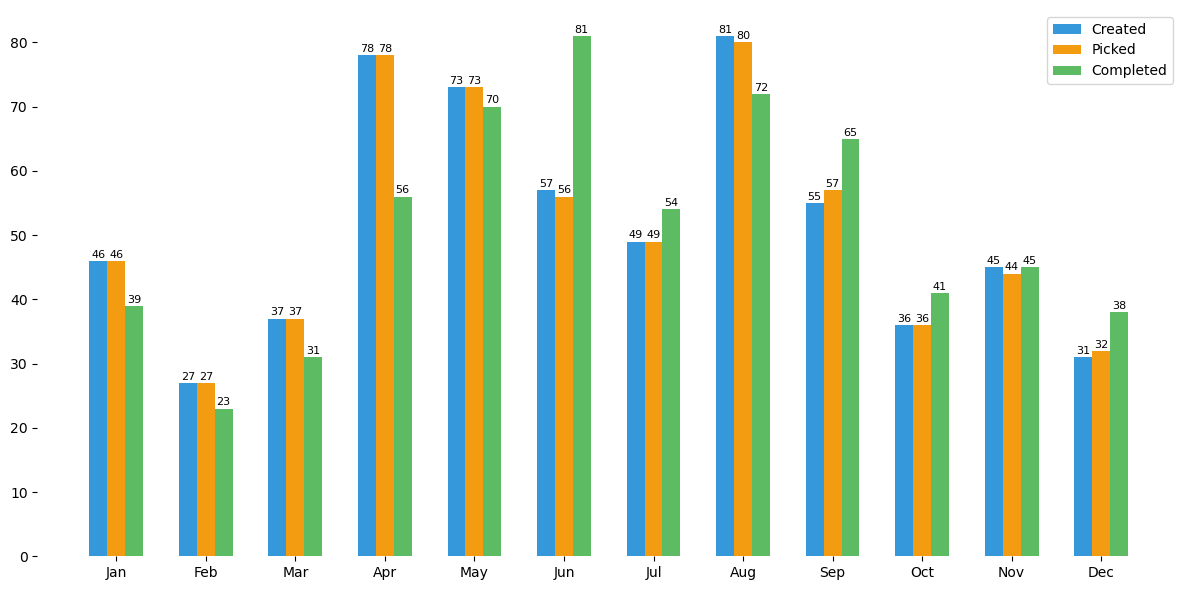

Team productivity (monthly) : 1.01


In [13]:
# Dataset
cr_month = plt_df.groupby('month created')['Ticket No'].count()
pk_month = plt_df.groupby('month picked')['Ticket No'].count()
cmp_month = plt_df.groupby('month completed')['Ticket No'].count()

month_df = pd.concat([cr_month,pk_month, cmp_month], axis=1)
month_df.columns = ['Created' ,'Picked', 'Completed']
month_df['productivity score'] = month_df['Completed'] / month_df['Picked']
month_corr = str(round(month_df['Picked'].corr(month_df['Completed']),2))
month_pd_score = str(round(month_df['productivity score'].mean(),2))
month_df.to_excel('./Data/month trend.xlsx')

plt.figure(figsize=(12,6))
x = np.arange(12)
width = 0.2
cr_bar = plt.bar(x-0.2, month_df['Created'], width,color = '#3498DB')
pk_bar = plt.bar(x,month_df['Picked'], width,color = '#F39C12')
cmp_bar = plt.bar(x+0.2, month_df['Completed'], width,color='#5DBB63')
plt.xticks(x, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec'])

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.legend(["Created", "Picked", "Completed"])

for bari in cr_bar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()+0.5, str(int(height)),
                 ha='center', color='black', fontsize=8)
    
for bari in pk_bar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()+0.5, str(int(height)),
                    ha='center', color='black', fontsize=8)

for bari in cmp_bar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()+0.5, str(int(height)),
                    ha='center', color='black', fontsize=8)
plt.show()

print("Team productivity (monthly) :",round(month_df['productivity score'].mean(),2))

In [14]:
month_df

,Created,Picked,Completed,productivity score
Jan,46,46,39,0.847826
Feb,27,27,23,0.851852
Mar,37,37,31,0.837838
Apr,78,78,56,0.717949
May,73,73,70,0.958904
Jun,57,56,81,1.446429
Jul,49,49,54,1.102041
Aug,81,80,72,0.900000
Sep,55,57,65,1.140351
Oct,36,36,41,1.138889


#### what is the productivity score of April & June? why is the too many cases completed on Jun with relatively low tickets picked?

+ Productivity score (Apr) 0.72 - Low
+ Productivity score (Jun) 1.45 - High
+ The 56 tickets completed on April was picked on the same month rest of the tickets completed through out the month
+ Tickets Completed on June were high as there were also cases picked on firts 4 months 2 (22 tickets)


In [15]:
CSS = """
div.cell:nth-child(5) .output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

print('Productivity score (Apr)',month_df[month_df.index=='Apr']['productivity score'].values)
print('Productivity score (Jun)',month_df[month_df.index=='Jun']['productivity score'].values)

apr_cmp = plt_df[plt_df['month picked'] == 'Apr']
jun_cmp = plt_df[plt_df['month completed'] == 'Jun']

# When was the case picked on apr completed was most on the cases on jun?
""" 
    Most of the cases completed by Apr was picked on Apr itself and few on next month
"""
apr_grp = pd.DataFrame(apr_cmp.groupby('month completed')['Ticket No'].count())
apr_grp.rename(columns={'Ticket No':'# Tickets'}, inplace= True)
apr_grp.reset_index(inplace = True)

# When was the cases completed on Jun picked up? 
""" 
    Most of the cases picked on Jun was completed by Jun itself but nearly 20% of the cases were picked on the first four monts
"""
jun_grp = pd.DataFrame(jun_cmp.groupby('month picked')['Ticket No'].count())
jun_grp.rename(columns={'Ticket No':'# Tickets'}, inplace= True)
jun_grp.reset_index(inplace = True)

df1_styler = apr_grp.style.set_table_attributes("style='display:inline'").set_caption('Tikcets picked on April')
df2_styler = jun_grp.style.set_table_attributes("style='display:inline'").set_caption('Tikcets completed on June')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)


Productivity score (Apr) [0.71794872]
Productivity score (Jun) [1.44642857]


,month completed,# Tickets
0,Jan,0
1,Feb,0
2,Mar,0
3,Apr,56
4,May,16
5,Jun,2
6,Jul,2
7,Aug,1
8,Sep,1
9,Oct,0


## Category Analysis

#### How many cases have been worked in each category and Sub-Category?

In [16]:
sun = pd.DataFrame(plt_df.groupby(['Category','Sub Category'])['Ticket No'].count())
sun.reset_index(inplace= True)
sun.rename(columns={'Ticket No':'No.of Tickets'}, inplace= True)
sun.to_excel('sunburst.xlsx')

px.sunburst(sun, path=['Category', 'Sub Category'], values='No.of Tickets',
            color_discrete_sequence=px.colors.qualitative.Pastel,
            width=800, height=600)

### How many cases that took long days to complete?

+ 81 tickets took longer than the usual days of completion

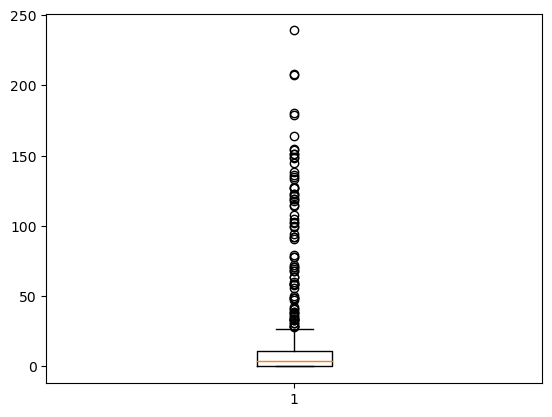

Number of Tickets took long days : 81


In [52]:
## IQR method

# Box plot to visualize outliers
plt.boxplot(plt_df['Days to complete'])
plt.show()

# find the outlier data
Q1 = plt_df['Days to complete'].quantile(0.25)
Q3 = plt_df['Days to complete'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

long_days = plt_df[(plt_df['Days to complete']<lower_bound) | (plt_df['Days to complete']>upper_bound)]
print('Number of Tickets took long days :',long_days.shape[0])



Number of Tickets took long days : 38


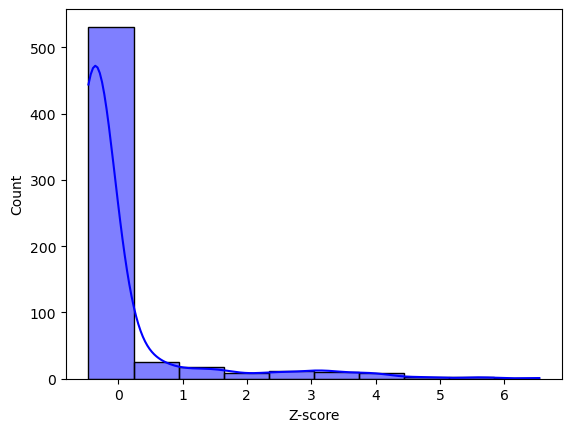

In [51]:
# Z-score method

plt_df['Z-score']= zscore(plt_df['Days to complete'])
outliers = plt_df[abs(plt_df['Z-score']) > 2]
sns.histplot(plt_df['Z-score'], kde=True, color='blue', bins=10)
print('Number of Tickets took long days :',outliers.shape[0])

### List the number of cases in each sub category that took long days

+ 20% of the tickets that took long days were Insider Threat with avg. day of 109 days to complete
+ Obsolete Software almost took 5.3 months to complete

+ some of the sub category that complete on time:
    - Encryption	
    - Network Security	
    - Secure Development	
    - Unauthorized access	
    - Unauthorized software	

In [49]:
# Create data to analyse the 
long_days_gp = pd.DataFrame(long_days.groupby('Sub Category').agg({
    'Ticket No': 'count',
    'Days to complete': 'mean'
}))
long_days_gp['Days to complete'] = long_days_gp['Days to complete'].astype(int)
long_days_gp.rename(columns={'Ticket No': 'Ticket_long_days','Days to complete':'DC_long_days'},inplace= True)
long_days_gp.reset_index(inplace= True)
long_days_gp.sort_values('DC_long_days', ascending= False)


,Sub Category,Ticket_long_days,DC_long_days
10,Obsolete Software,4,163
3,Database Security,1,115
7,Insider Threat,13,109
15,Segregation of Duties,2,108
2,BCP/DR,4,105
11,PCI-DSS,2,104
17,Third Party Engagement,2,95
9,New Application Launch,2,92
5,GDPR,8,91
13,Phishing,8,84


#### What is the time taken to complete each sub category?

+ The HIPPA (Health Insurance Portability and Accountability Act) tickets were completed in 4 days
+ With almost equal number of tickets on GDPR (General Data Protection Regulation)	were completed in 3 days
+ The password non-expiry tickets(#tickets 12) was unusal days to complete.

In [53]:
# Create data to analysis sub category
sub_cat = plt_df[(plt_df['Days to complete']>=lower_bound) & (plt_df['Days to complete']<=upper_bound)]
sub_cat_df = pd.DataFrame(sub_cat.groupby('Sub Category').agg({
    'Ticket No': 'count',
    'Days to complete': 'mean'
}))
sub_cat_df['Days to complete'] = sub_cat_df['Days to complete'].astype(int)
sub_cat_df.rename(columns={'Ticket No': 'usual tickets','Days to complete':'usual days'},inplace= True)
sub_cat_df.reset_index(inplace= True)
sub_cat_df


sub_cat_gp = pd.merge(long_days_gp,sub_cat_df, on='Sub Category', how='outer')
sub_cat_gp.replace(np.NaN,0,inplace=True)
sub_cat_gp['total tickets'] = sub_cat_gp['Ticket_long_days'] + sub_cat_gp['usual tickets']

sub_cat_gp.to_excel('./Data/Sub category.xlsx')


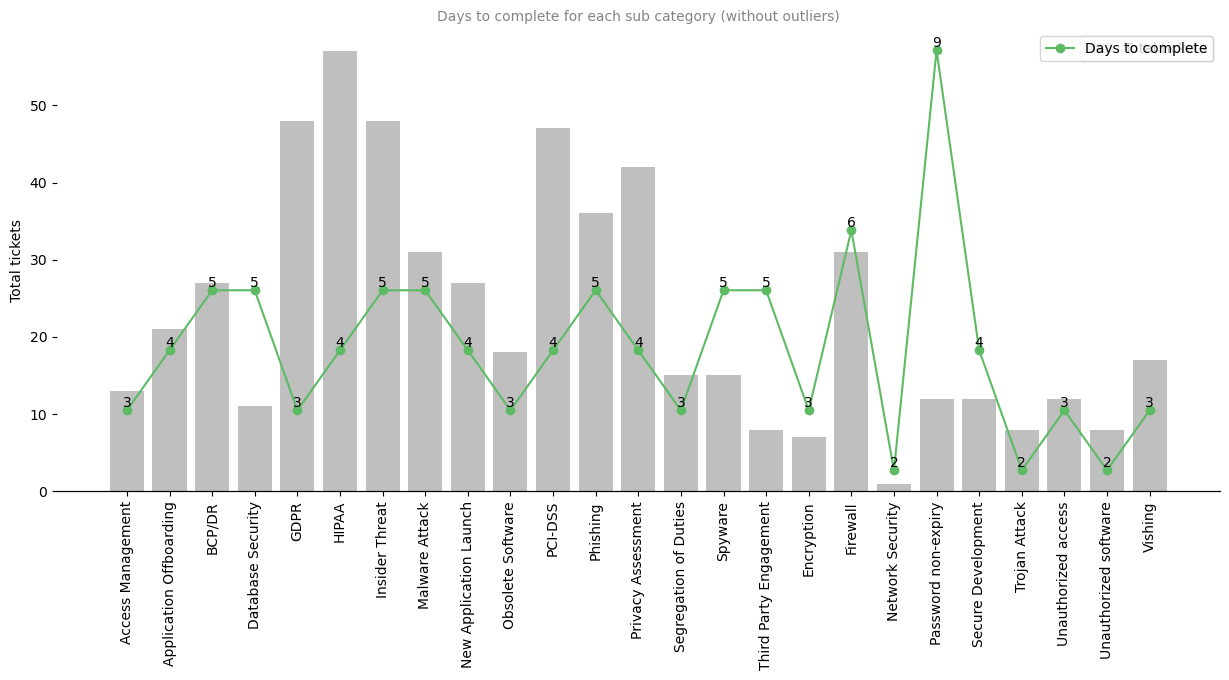

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create a line plot
ax.bar(sub_cat_gp['Sub Category'], sub_cat_gp['total tickets'], color='grey', alpha=0.5, label ='Total tickets')  # alpha controls transparency


ax2 = ax.twinx()
# Create a bar plot
ax2.plot(sub_cat_gp['Sub Category'], sub_cat_gp['usual days'], color='#5DBB63', label='Days to complete',marker='o')

# Annotate the line plot
for i, value in enumerate(sub_cat_gp['usual days']):
    ax2.text(i, value, str(value), ha='center', va='bottom')


# Set labels and title
ax.set_xticks(sub_cat_gp.index)
ax.set_xticklabels(sub_cat_gp['Sub Category'],rotation = 90)

ax.set_ylabel('Total tickets')
ax2.set(yticks=[])
ax2.set_title('Days to complete for each sub category (without outliers)',fontsize=10, color = '#818589')
#ax2.set_ylabel('Days to complete')

sns.despine(left=True)
# Add legend
ax.legend()
ax2.legend()

# Show the plot
plt.show()

#### Did the priority of the password-expiry tickets had an effect on days of completion?

+ There is no contribution by the priority to the days of completion
+ for all 3 types of priority the Average days to completion is near a week

In [22]:
pass_exp = sub_cat[sub_cat['Sub Category'] == 'Password non-expiry']
password = pass_exp.groupby('Priority').agg({
    'Ticket No': 'count',
    'Days to complete': 'mean'
})
password['Days to complete'] = password['Days to complete'].astype(int)
password.rename(columns={'Ticket No': 'Ticket count','Days to complete':'Avg. Days to complete'},inplace= True)
password.reset_index(inplace= True)

password.sort_values('Ticket count',ascending= False)

,Priority,Ticket count,Avg. Days to complete
1,Low,6,10
2,Medium,4,9
0,High,2,7


#### Which sub category had the most high priority tickets?

In [23]:
high_p = plt_df[plt_df['Priority'] == 'High']
high_p_sub_cat_gp = grp_df(high_p, ['Sub Category'], {'Ticket No':'count'})
print('Total High priority tickets: ', high_p.shape[0])
high_p_sub_cat_gp.sort_values('Ticket No', ascending= False)

Total High priority tickets:  291


,Sub Category,Ticket No
5,Firewall,34
9,Malware Attack,34
6,GDPR,30
8,Insider Threat,25
7,HIPAA,24
14,Phishing,17
18,Spyware,16
2,BCP/DR,15
12,PCI-DSS,14
1,Application Offboarding,12


## Demographic Analysis

#### Which state contributed to maximum work in the year 2021?

+ The top 10 states alone sum upto creating 65% of the tickets during the year 2021.
+  California alone create 21% of the tickets in the year 2021.

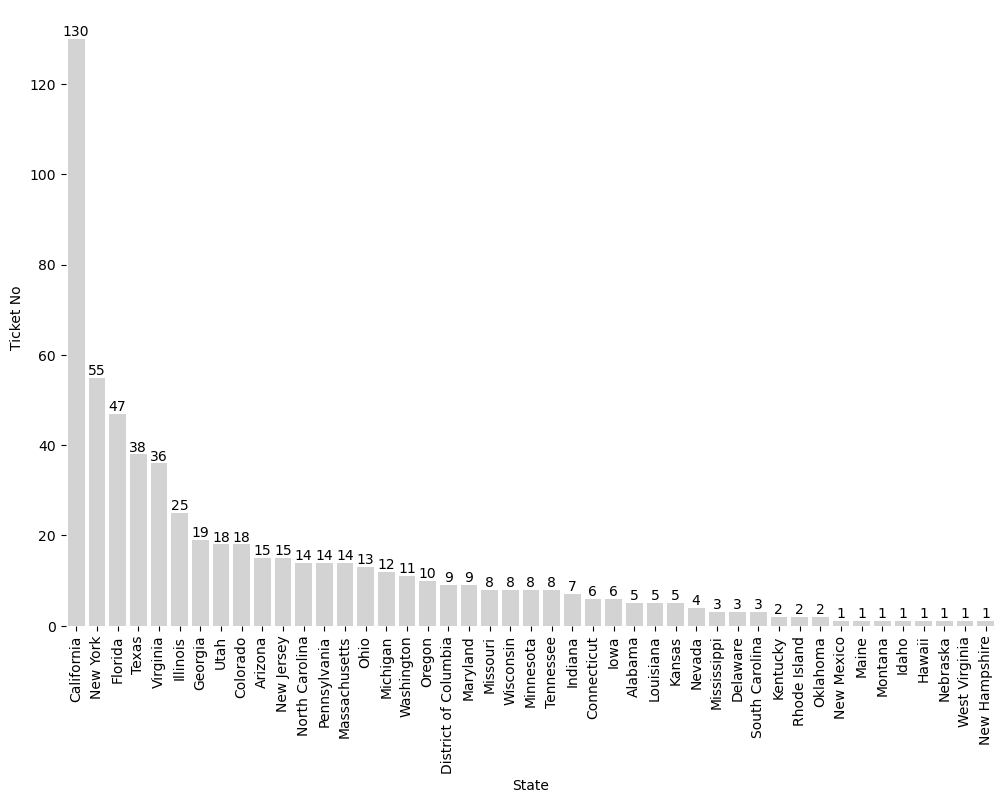

In [24]:
most_case = grp_df(plt_df,['State'],{'Ticket No':'count'})
most_case.to_excel('./Data/Demographic.xlsx')

barplot(most_case['State'], most_case['Ticket No'], rotation=90, 
        order=most_case.sort_values('Ticket No',ascending = False).State, color='lightgrey')

#### Which state raised most of the high prioirty tickets?

+ 83 % percent of the case created by Michigan is a High priority tickets
+ ~50% of the tickets created Florida, Texas, Virgina, Utah, Colorado and Pennsylvania are high priority tickets

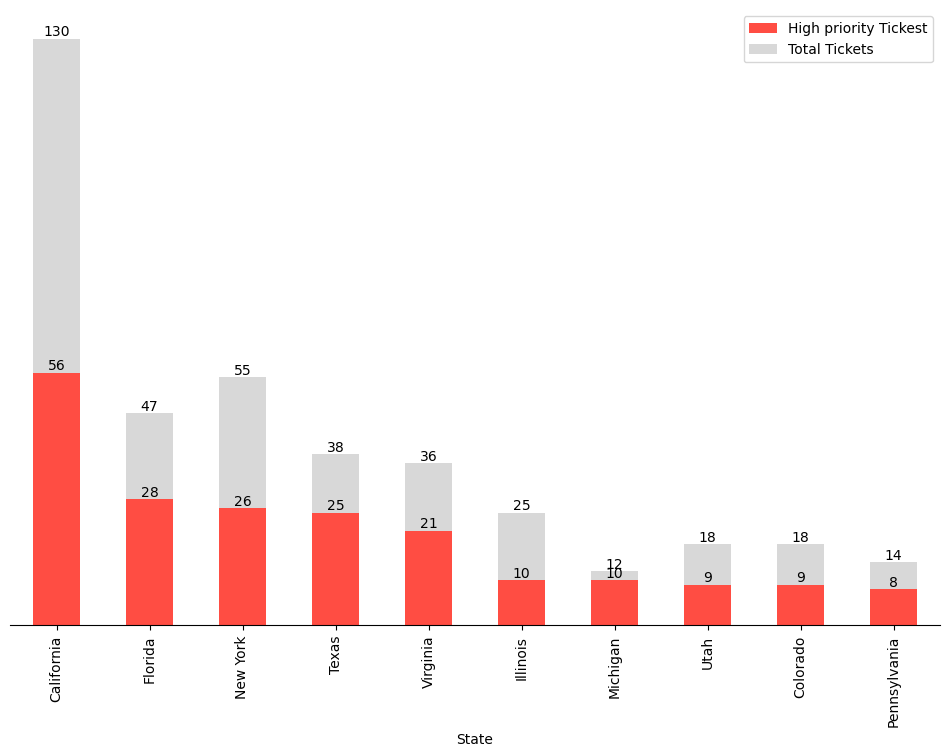

In [25]:
# Create df State-priority grouped
state_p_tkt = grp_df(plt_df,['State','Priority'],{'Ticket No':'count'})

# Combine to get total case
cmb_df = pd.merge(state_p_tkt, most_case, on ='State', how='outer')
cmb_df.to_excel('./Data/priority.xlsx')
# Update the df for ploting
high_p_tkt = cmb_df[cmb_df['Priority']=='High'].sort_values('Ticket No_x',ascending= False)[:10]
high_p_tkt['Total Tickets'] = high_p_tkt['Ticket No_y'] - high_p_tkt['Ticket No_x']
high_p_tkt.rename(columns={'Ticket No_x': 'High priority Tickest'}, inplace=True)
high_p_tkt.drop(columns=['Priority', 'Ticket No_y'], inplace= True)
high_p_tkt.set_index('State', inplace= True)

# Plot the data
ax =high_p_tkt.plot(kind = 'bar', stacked = True, color = ['#ff4d43','#D8D8D8'], figsize = (12,8))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set(yticks=[])
sns.despine(left=True)


#### On the month of April and Aug which state raised most of the tickets?

+ More than 50% of cases created on April and Aug were created by
    - California
    - New york
    - Texas
    - Virginia
    - Florida

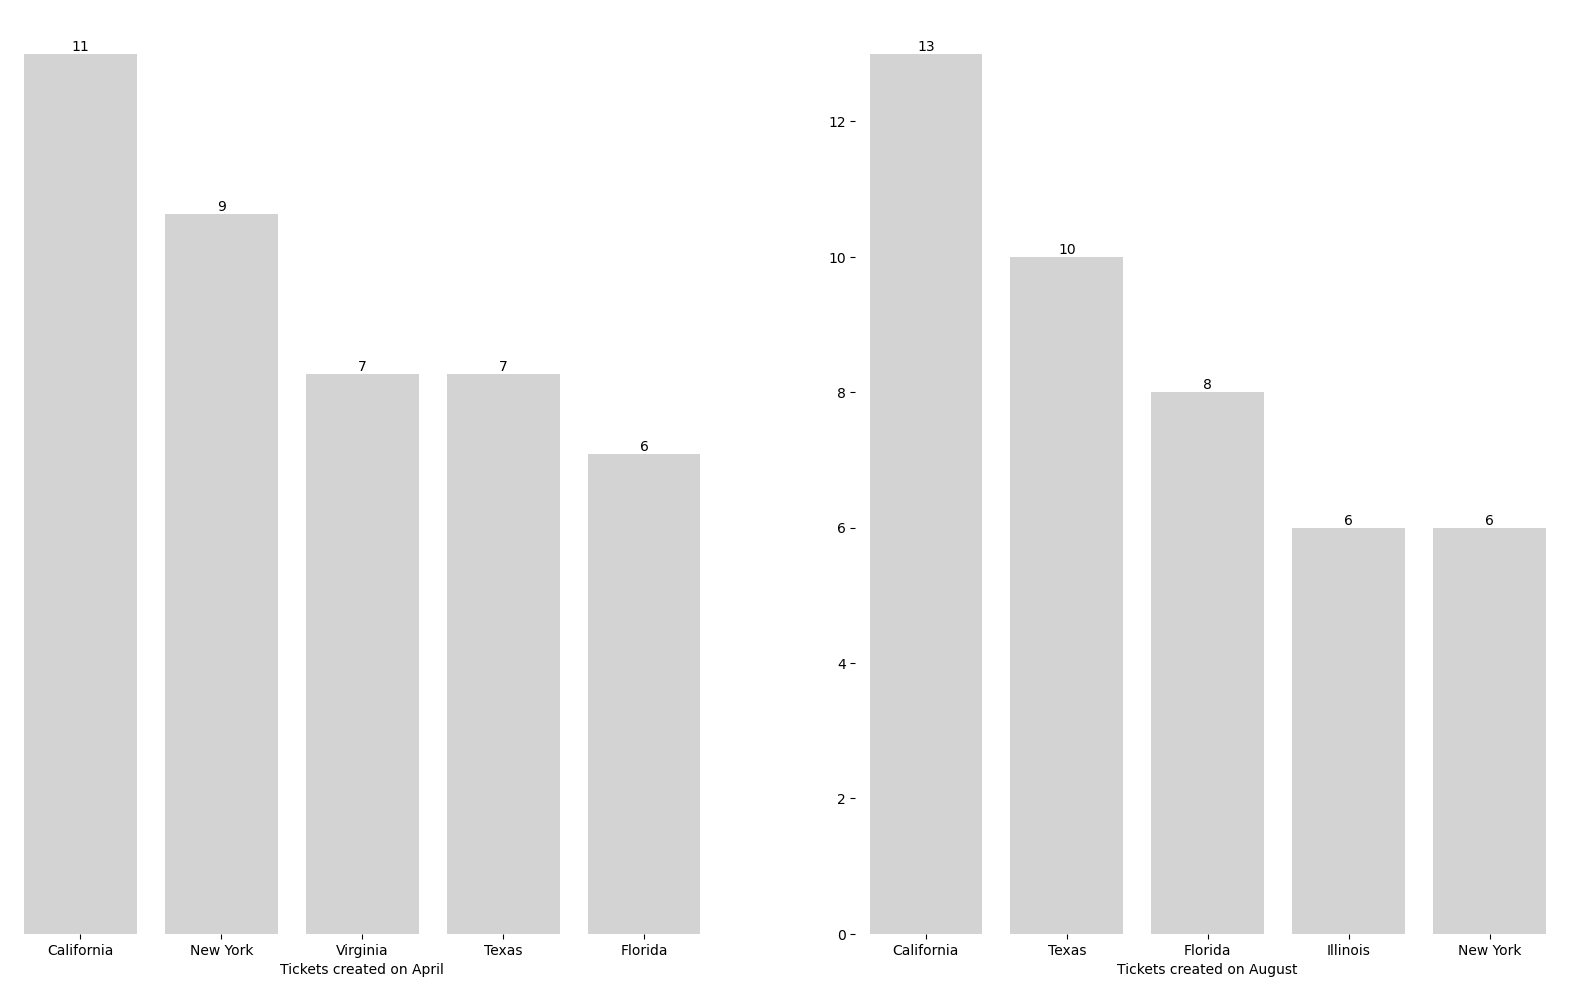

In [26]:
dumb_df = plt_df[(plt_df['month created'] =='Apr') | (plt_df['month created'] =='Aug')]
dumb_df_grp = pd.DataFrame(dumb_df.groupby(['State','month created'])['Ticket No'].count())
dumb_df_grp.reset_index(inplace= True)

apr_top5 = dumb_df_grp[dumb_df_grp['month created'] =='Apr'].sort_values('Ticket No',ascending=False)[:5]
aug_top5 = dumb_df_grp[dumb_df_grp['month created'] =='Aug'].sort_values('Ticket No',ascending=False)[:5]
dumb_df.to_excel('./Data/apr aug.xlsx')
# Subplots
fig, ax = plt.subplots(1,2,figsize = (20,12))
#fig.suptitle('Tickets created on April')

# Plot 1 - Tickets Completed (Meaning the tickets are closed / becomes Inactive )
p1 = sns.barplot (x = apr_top5['State'], y = apr_top5['Ticket No'],  ax = ax[0], color = 'lightgrey')

p1.bar_label(p1.containers[0], label_type = 'edge')
p1.set(yticks = [],ylabel = '',xlabel= 'Tickets created on April')



# Plot 2 - Tickets Picked (Meaning the tickets are picked / becomes active )
p2 = sns.barplot (x = aug_top5['State'], y = aug_top5['Ticket No'],  ax = ax[1] , color = 'lightgrey')
p2.bar_label(p2.containers[0], label_type= 'edge')
p2.set(ylabel = '',xlabel= 'Tickets created on August')

sns.despine(bottom = True, left = True)
plt.show()


#### Which state created most of the HIPPA tickets?
+ California had the highest HIPAA tickets throught the year 2021
+ Utah had 7 out of 18 tickets to be HIPAA which almost 38% 

In [27]:
hippa_tkt = plt_df[plt_df['Sub Category'] == 'HIPAA']
hippa_tkt_gp = grp_df(hippa_tkt,['State'],{'Ticket No':'count'})
hippa_tkt_gp.rename(columns={'Ticket No': 'Ticket count'}, inplace= True)
hippa_tkt_gp.sort_values('Ticket count',ascending= False)[:5]

,State,Ticket count
1,California,9
16,Utah,7
2,Colorado,6
15,Texas,5
0,Arizona,4


#### The tickets that took long days are from which state?

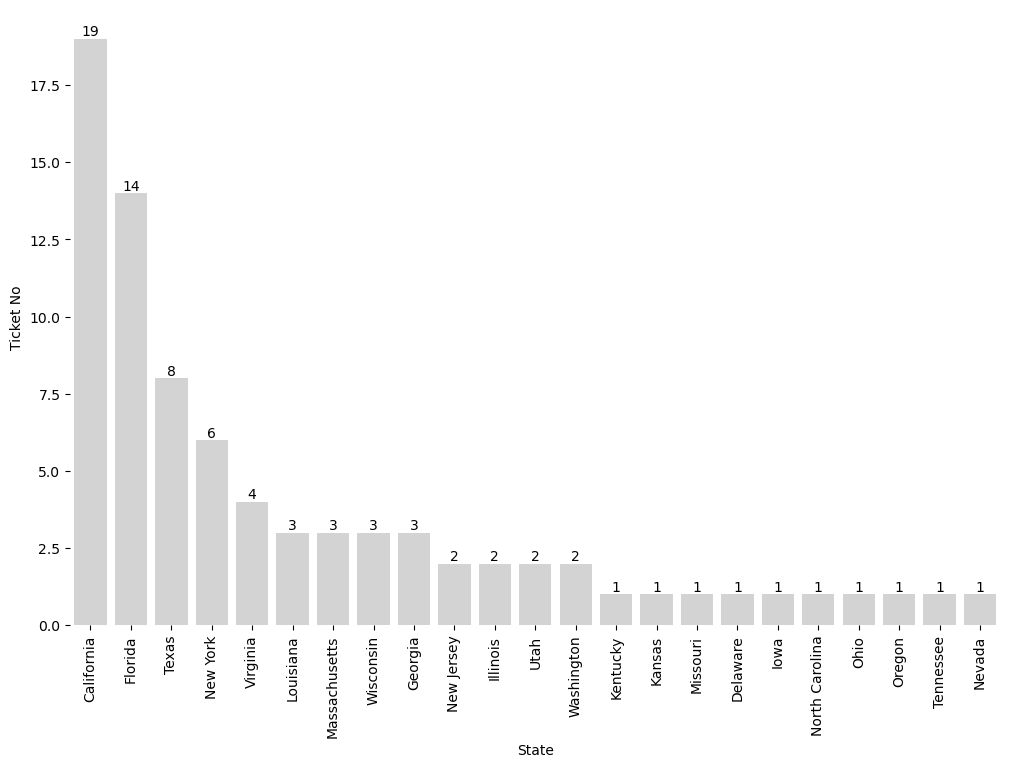

In [28]:
long_days_state_gp = grp_df(long_days,['State'],{'Ticket No': 'count'})
long_days_gp.to_excel('./Data/long data tickets.xlsx')
barplot(long_days_state_gp['State'],long_days_state_gp['Ticket No'],rotation=90, color= 'lightgrey',
        order = long_days_state_gp.sort_values('Ticket No',ascending = False).State)

## Rating Analysis

### Rating of tickets - Normal Vs Long Days

In [29]:
long_days['Rating'].mean(), sub_cat['Rating'].mean()
long_days['Days to complete'].corr(long_days['Rating']), sub_cat['Days to complete'].corr(sub_cat['Rating'])

(0.056797844298671324, 0.07237485854937124)

#### Which Assignee has recieved the highest unsatisfactory rating?
+ Sebastian has highest unstatisfactory rating, 28% of his works are rated unsatisfactory.

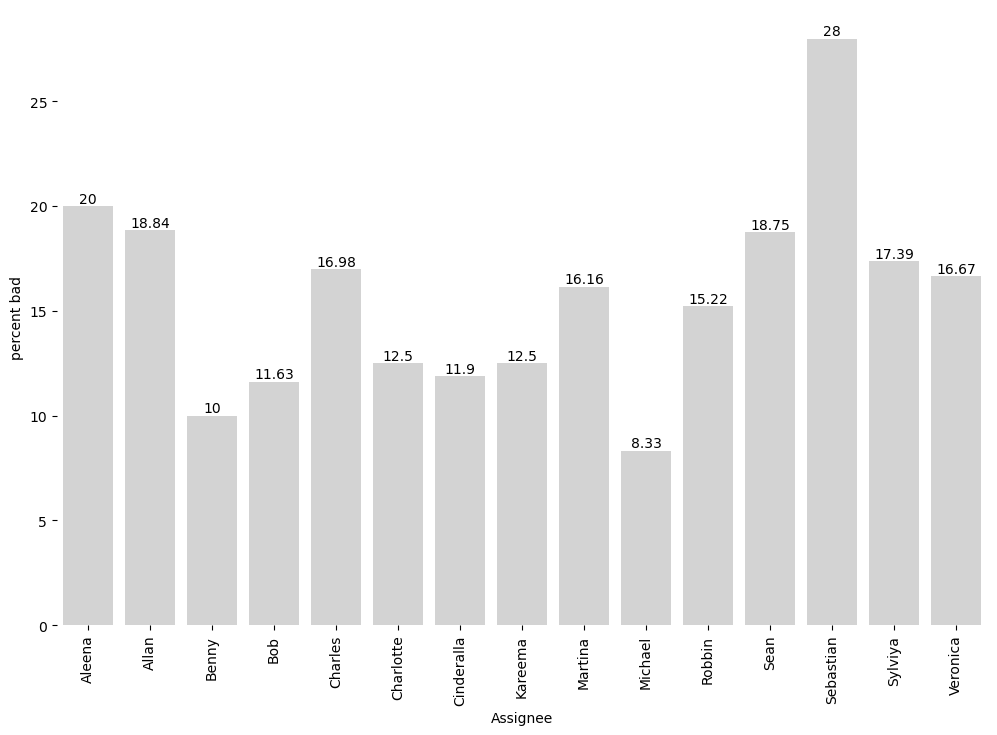

In [30]:
asgn_tkt = grp_df(plt_df,['Assignee'],{'Ticket No':'count'})
unsatis = plt_df[plt_df['Customer Rating']=='Unsatisfactory (2)']
unsatis_gp = grp_df(unsatis,['Assignee'],{'Ticket No':'count'})

asgn_unsatis = pd.merge(asgn_tkt, unsatis_gp, on = 'Assignee', how = 'outer')
asgn_unsatis['good tickets'] = asgn_unsatis['Ticket No_x'] - asgn_unsatis['Ticket No_y']
asgn_unsatis['percent bad'] = round((asgn_unsatis['Ticket No_y']/asgn_unsatis['Ticket No_x'])*100,2)
asgn_unsatis.rename(columns={'Ticket No_y':'bad tickets'}, inplace= True)
asgn_unsatis.drop(columns={'Ticket No_x'},inplace=True)
asgn_unsatis.to_excel('./Data/unsatis.xlsx')
"""asgn_unsatis.set_index('Assignee', inplace= True)
asgn_unsatis = asgn_unsatis.sort_values('bad tickets', ascending=False)

# Plot the data
ax =asgn_unsatis.plot(kind = 'bar', stacked = True, color = ['#ff4d43','#D8D8D8'], figsize = (12,8))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set(yticks=[])
sns.despine(left=True)"""
barplot(x=asgn_unsatis['Assignee'],y=asgn_unsatis['percent bad'],rotation=90,color='lightgrey')


#### Which sub category has recieved the most unsatisfactory rating?
+ Insider Threat, Phising, New Application Launch, HIPPA and PCI-DSS has the highest number of tickets with unsatisfactory rating

In [57]:
unsatis_sub_cat = grp_df(unsatis,['Sub Category'],{'Ticket No':'count'})
unsatis_sub_cat.sort_values('Ticket No', ascending= False)

,Sub Category,Ticket No
8,Insider Threat,11
14,Phishing,10
11,New Application Launch,10
7,HIPAA,10
13,PCI-DSS,9
15,Privacy Assessment,7
9,Malware Attack,5
6,GDPR,5
17,Third Party Engagement,4
2,BCP/DR,4


#### Which sub category had the lowest average rating?

In [31]:
low_rat = grp_df(plt_df,['Category','Sub Category'],{'Ticket No':'count','Rating':'mean'})
low_rat = low_rat.sort_values('Rating')
low_rat.rename(columns={'Ticket No': 'No. of Tickets', 'Rating':'Avg. Rating'}, inplace =  True)
low_rat['Avg. Rating'] = round(low_rat['Avg. Rating'],1)
low_rat.to_excel('./Data/low rats.xlsx')

low_rat = low_rat[:10]
low_rat


,Category,Sub Category,No. of Tickets,Avg. Rating
5,Cyber Consultation,Network Security,1,2.0
9,Cyber Consultation,Third Party Engagement,9,3.3
6,Cyber Consultation,New Application Launch,28,3.4
4,Cyber Consultation,Encryption,7,3.4
13,Cyber Security Breach,Trojan Attack,10,3.5
21,Security Gap,Obsolete Software,18,3.6
15,Data Leak,Phishing,40,3.9
3,Cyber Consultation,Database Security,11,3.9
2,Cyber Consultation,BCP/DR,29,3.9
24,Security Gap,Unauthorized software,8,4.0


## Individual Analysis

#### Which individual had the highest and lowest average productivity score in the year 2021?

+ Sylvia has the highest productivity score of 1.17 with the total contribution of 3% to the team

In [32]:
asgn_pk = plt_df.groupby(['Assignee', 'month picked'])['Ticket No'].count()
asgn_cmp = plt_df.groupby(['Assignee', 'month completed'])['Ticket No'].count()
asgn_month = pd.concat([asgn_pk, asgn_cmp], axis=1)
asgn_month.reset_index(inplace=True)
asgn_month.columns = [ 'Assignee','Month','Picked', 'Completed']
asgn_month['productivity score'] = np.divide(asgn_month['Completed'],asgn_month['Picked'])

# if picked = 0 and completed = 0 replace it with 0 (No producitiviy)
asgn_month['productivity score'].replace(np.NaN,0, inplace= True)

# if picked = 0 and completed > 0 replace it with 0 (No producitiviy)
asgn_month['productivity score'].replace(np.inf,0, inplace= True)

allan = asgn_month[asgn_month['Assignee'] == "Sylviya"]
asgn_month.to_excel('./Data/Assignee prod.xlsx')


In [33]:
asgn_month.groupby('Assignee')['productivity score'].mean()

Assignee
Aleena        0.697917
Allan         0.932930
Benny         0.416667
Bob           0.938889
Charles       0.848148
Charlotte     0.991667
Cinderalla    0.886508
Kareema       1.017361
Martina       1.084210
Michael       0.774964
Robbin        0.842460
Sean          0.743056
Sebastian     1.111111
Sylviya       1.172222
Veronica      0.948985
Name: productivity score, dtype: float64

In [56]:
asgn_long_tkt = grp_df(long_days,['Assignee'],{'Ticket No':'count'})

asgn_long_tkt_percent = pd.merge(asgn_long_tkt,asgn_tkt, on = 'Assignee', how = 'inner')
asgn_long_tkt_percent['long tkt percent'] = round((asgn_long_tkt_percent['Ticket No_x'] / asgn_long_tkt_percent['Ticket No_y'])*100,2)
asgn_long_tkt_percent['percent of total contribution'] = round((asgn_long_tkt_percent['Ticket No_y']/plt_df.shape[0])*100,2)
asgn_long_tkt_percent.rename(columns={'Ticket No_x':'long Days tkt','Ticket No_y': 'Total tickets'}, inplace = True)
asgn_long_tkt_percent.to_excel('./Data/asgn long tickets percent.xlsx')
asgn_long_tkt_percent

,Assignee,long Days tkt,Total tickets,long tkt percent,percent of total contribution
0,Aleena,5,25,20.00,4.07
1,Allan,8,69,11.59,11.22
2,Benny,1,30,3.33,4.88
3,Bob,7,43,16.28,6.99
4,Charles,2,53,3.77,8.62
5,Charlotte,1,24,4.17,3.90
6,Cinderalla,2,42,4.76,6.83
7,Kareema,6,32,18.75,5.20
8,Martina,21,99,21.21,16.10
9,Michael,5,36,13.89,5.85


## Conclusions

+ The **inflow of tickets are less during the month of Feb, Mar, Oct and Nov**. We can use this time effectively in **improving our team with training or KT sessions on the category we received low rating.**

+ As we recieve more tickets on Data privacy and Cyber consulation we can **request the products implemenation / Development team to improve the Data handling in more effective way.**

+ The **password non-expiry** category ticket takes more than usual days of completion we can request for more **insights from the manager.**

+ By setting a standard for indiviuals in the **rate of the unsatifactory(2) tickets < 15%** (1/10 tickets can recieve rating = 2 ).

+ Eventhough the **producitvity scores of the individuals seem okish the total contribution to the team of few are very low.** This might be possibly due to new hires, lack of technical expertise etc.

## Recommendation (Improving Analysis):
+ By shifiting from Days of completion -> Hours of completion we will be able to find the the tickets that truly takes longer time to complete.

+ We can include a new data table to have the basic work details of an employee. The columns to be included are Total experience, years of service in the team, expertise. This will help measure the impact of an individual in a ticket.